In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import json

### READ IN DAILY DATA

In [6]:
states = pd.read_csv("./daily_data/nyt_states.csv")

counties = pd.read_csv("./daily_data/nyt_counties.csv")

testing = pd.read_csv("./daily_data/covid_tracking.csv")

## Prep County Data

In [7]:
counties["date"] = pd.to_datetime(counties.date, format = "%Y-%m-%d")

counties = counties.sort_values(by = ["county", "date" ]).reset_index(drop = True)

counties.head()

,date,county,state,fips,cases,deaths
0,2020-03-19,Abbeville,South Carolina,45001.0,1,0
1,2020-03-20,Abbeville,South Carolina,45001.0,1,0
2,2020-03-21,Abbeville,South Carolina,45001.0,1,0
3,2020-03-22,Abbeville,South Carolina,45001.0,1,0
4,2020-03-23,Abbeville,South Carolina,45001.0,1,0


In [8]:
unknown_indices = counties[counties.county == "Unknown"].index ## drop state level observations

counties = counties.drop(unknown_indices, axis = 0).reset_index(drop = True)

counties[counties.fips.isnull()].county.unique()

array(['Kansas City', 'New York City'], dtype=object)

In [9]:
kc_indices = counties[counties.county == "Kansas City"].index

ny_indices = counties[counties.county == "New York City"].index

for i in kc_indices:
    
    counties.at[i, "fips"] = -1 #assign non-null value so I can index through all counties by fips
                                #having an issue with shared county names
for j in ny_indices:
    
    counties.at[j, "fips"] = 36061
    
#check my work
print(len(counties[counties.fips.isnull()]))

0


In [10]:
counties.head()

,date,county,state,fips,cases,deaths
0,2020-03-19,Abbeville,South Carolina,45001.0,1,0
1,2020-03-20,Abbeville,South Carolina,45001.0,1,0
2,2020-03-21,Abbeville,South Carolina,45001.0,1,0
3,2020-03-22,Abbeville,South Carolina,45001.0,1,0
4,2020-03-23,Abbeville,South Carolina,45001.0,1,0


In [11]:
county_frames = []

for cty in counties.fips.unique():
    
    county_df = counties[counties.fips == cty]
    
    county_df = county_df.sort_values(by = ["date"]).reset_index(drop = True) #ensure correct order
    
    if len(county_df) > 1:
        
        growth_rates = [0]
        
        for k in range(1, len(county_df)):
            
            growth_rates.append((county_df.iloc[k]["cases"] / county_df.iloc[k-1]["cases"]) - 1)
            
        growth_rates = pd.Series(growth_rates).rename("daily_growth_rate")
        
    else:
        
        growth_rates = pd.Series([-1]).rename("daily_growth_rate")
        
    assert len(growth_rates) == len(county_df)

    county_df = pd.concat([county_df, growth_rates], axis = 1)

    county_frames.append(county_df)

In [12]:
all_county = pd.concat(county_frames, axis = 0).reset_index(drop = True)

all_county.head()

,date,county,state,fips,cases,deaths,daily_growth_rate
0,2020-03-19,Abbeville,South Carolina,45001.0,1,0,0.0
1,2020-03-20,Abbeville,South Carolina,45001.0,1,0,0.0
2,2020-03-21,Abbeville,South Carolina,45001.0,1,0,0.0
3,2020-03-22,Abbeville,South Carolina,45001.0,1,0,0.0
4,2020-03-23,Abbeville,South Carolina,45001.0,1,0,0.0


In [13]:
del county_frames

del counties

## Prepare State Data

In [14]:
states["date"] = pd.to_datetime(states.date, format = "%Y-%m-%d")

states = states.sort_values(by = ["state", "date"]).reset_index(drop = True)

In [15]:
state_frames = []

for st in states.fips.unique():
    
    state_df = states[states.fips == st]
    
    state_df = state_df.sort_values(by = ["date"]).reset_index(drop = True) #ensure correct order
    
    if len(state_df) > 1:
        
        growth_rates = [0]
        
        for k in range(1, len(state_df)):
            
            growth_rates.append((state_df.iloc[k]["cases"] / state_df.iloc[k-1]["cases"]) - 1)
            
        growth_rates = pd.Series(growth_rates).rename("daily_growth_rate")
        
    else:
        
        growth_rates = pd.Series([-1]).rename("daily_growth_rate")
        
    assert len(growth_rates) == len(state_df)

    state_df = pd.concat([state_df, growth_rates], axis = 1)

    state_frames.append(state_df)
    
all_state = pd.concat(state_frames, axis = 0).reset_index(drop = True)

all_state.head()

,date,state,fips,cases,deaths,daily_growth_rate
0,2020-03-13,Alabama,1,6,0,0.000000
1,2020-03-14,Alabama,1,12,0,1.000000
2,2020-03-15,Alabama,1,23,0,0.916667
3,2020-03-16,Alabama,1,29,0,0.260870
4,2020-03-17,Alabama,1,39,0,0.344828


In [16]:
from IPython.display import display, HTML

In [17]:
def get_hot_counties(state: str, n_most = 10, all_county = all_county):
    
    state_df = all_county[all_county.state == state].reset_index(drop = True)
    
    hotspots = state_df[state_df.date == state_df.date.max()].sort_values(by = ["cases"], 
                                                                  ascending = False).county.values[:n_most]
    county_dfs = {}
    
    hot_counties = []
    
    for cty in hotspots:
        
        cty_df = state_df[state_df.county == cty].reset_index(drop = True)
        
        county_dfs[cty] = cty_df
        
        d = {}
        
        d["county"] = cty
        
        d["first_case"] = cty_df.date.min()
        
        d["total_cases"] = cty_df.iloc[-1]["cases"]
        
        d["previous_day_growth_rate"] = "{}%".format(
            round(cty_df.iloc[-1]["daily_growth_rate"] * 100, 2))
        
        if len(cty_df) >= 3:
            
            d["3day_avg_growth_rate"] = "{}%".format(
                round(cty_df.iloc[-1:-4:-1]["daily_growth_rate"].mean() * 100, 2))
            
        else:
            
            d["3day_avg_growth_rate"] = "Not Available"
            
        if len(cty_df) >= 7:
            
            d["7day_avg_growth_rate"] = "{}%".format(
                round(cty_df.iloc[-1:-8:-1]["daily_growth_rate"].mean() * 100, 2))
            
        else:
            
            d["7day_avg_growth_rate"] = "Not Available"
            
        hot_counties.append(d)
        
    summary_df = pd.DataFrame(hot_counties)
    
    print("The {} most effected counties in {}:".format(n_most, state))
    
    display(summary_df)
    
    return(county_dfs)
            
def analyze_state(state: str or int or float, all_county = all_county, all_state = all_state):
    
    if type(state) == str:
        
        if " " not in state:
        
            state = state.capitalize()
        
        else:
            
            state = [i.capitalize() for i in state.split(" ")]
            
            state = " ".join(state)
        
        state_df = all_state[all_state.state == state].reset_index(drop = True)
        
        if len(state_df) == 0:
            
            state_df = all_state[all_state.state == state].reset_index(drop = True)
            
            if len(state_df) == 0:
                
                raise NameError("Please ensure state name is spelled correctly")
                
    elif type(state) == int or type(state) == float:
        
        state_df = all_state[all_state.fips == state].reset_index(drop = True)
        
        if len(state_df) == 0:
            
            raise NameError("Please ensure correct FIPS entered")
            
    else:
        
        raise ValueError("Incorrect value passed to state. Please enter state name or state FIPS code")
        
    state_name = state_df.iloc[0]["state"]
    
    if len(state_df) == 1:
        
        return("{} recorded its first case of COVID-19 on {}, with {} total cases".format(
        state_name, state_df.iloc[-1]["date"], state_df.iloc[-1]["cases"]))
    
    else:
        
        print("{} reported its first cases of COVID-19 on {}, and has {} cases as of {}\n".format(
        state_name, state_df.date.min(), state_df.iloc[-1]["cases"], 
        state_df.date.max()))
        
        print("The previous daily growth rate was {}%\n".format(
            round(state_df.iloc[-1]["daily_growth_rate"] * 100, 2) ))
        
        if len(state_df) >= 3:
            
            _3day = state_df.iloc[-1:-4:-1].daily_growth_rate.mean()
            
            print("The 3 day average growth rate was {}%\n".format(
            round(_3day * 100, 2)))
            
        if len(state_df) >= 7:
            
            _7day = state_df.iloc[-1:-8:-1].daily_growth_rate.mean()
            
            print("The 7 day average growth rate was {}%\n".format(
            round(_7day * 100, 2)))
            
        c = get_hot_counties(state_name)
            
        fig, ax = plt.subplots(4, figsize = (15, 25))
        
        ax[0].scatter(state_df.date, state_df.cases, c = "k")
        
        ax[0].plot(state_df.date, state_df.cases)
        
        ax[0].set_title("Total Cases - {}".format(state_name), weight = "bold")
        
        ax[0].set_ylabel("Total Number of Cases", weight = "bold")
        
        ax[0].set_xlabel("Date", weight = "bold")
        
        ax[1].scatter(state_df.date, state_df.daily_growth_rate * 100, c = "k")
        
        ax[1].plot(state_df.date, state_df.daily_growth_rate * 100)
        
        ax[1].set_title("Daily Growth Rate - {}".format(state_name), weight = "bold")
        
        ax[1].set_ylabel("Percentage Growth (Case Numbers) from Previous Day", weight = "bold")
        
        ax[1].set_xlabel("Date", weight = "bold")
        
        for cty in c:
            
            ax[2].plot(c[cty].date, c[cty].cases, label = cty)
            
            ax[2].text(c[cty].iloc[-1]["date"], c[cty].iloc[-1]["cases"], c[cty].iloc[-1]["cases"],
                        horizontalalignment='left', weight = "bold")
            
            ax[3].plot(c[cty].date, c[cty].daily_growth_rate * 100, label = cty)
        
        ax[2].legend(bbox_to_anchor=(0.00, 1), loc='upper left', borderaxespad=0)
        
        ax[2].set_title("Cases by County - {}".format(state_name), weight = "bold")
        
        ax[2].set_ylabel("Number of Cases", weight = "bold")
        
        ax[2].set_xlabel("Date", weight = "bold")
        
        ax[3].legend(bbox_to_anchor=(0.00, 1), loc = "upper left", borderaxespad=0)
        
        ax[3].set_title("Daily Growth Rate by County - {}".format(state_name), weight = "bold")
        
        ax[3].set_ylabel("Percentage Growth (Caase Numbers) from Previous Day", weight = "bold")
        
        ax[3].set_xlabel("Date", weight = "bold")

California reported its first cases of COVID-19 on 2020-01-25 00:00:00, and has 13796 cases as of 2020-04-04 00:00:00

The previous daily growth rate was 9.76%

The 3 day average growth rate was 12.03%

The 7 day average growth rate was 13.88%

The 10 most effected counties in California:


,county,first_case,total_cases,previous_day_growth_rate,3day_avg_growth_rate,7day_avg_growth_rate
0,Los Angeles,2020-01-26,5277,15.57%,14.48%,16.6%
1,San Diego,2020-02-10,1209,8.72%,12.54%,13.94%
2,Santa Clara,2020-01-31,1148,4.94%,6.46%,10.33%
3,Orange,2020-01-25,786,10.55%,9.29%,14.1%
4,Riverside,2020-03-07,665,4.23%,22.18%,21.24%
5,San Mateo,2020-03-02,538,10.7%,11.58%,10.42%
6,San Francisco,2020-02-02,529,5.8%,6.63%,8.07%
7,Alameda,2020-03-01,464,0.0%,7.0%,7.74%
8,Sacramento,2020-02-21,411,5.66%,9.45%,15.02%
9,Contra Costa,2020-03-03,353,14.98%,12.21%,11.28%


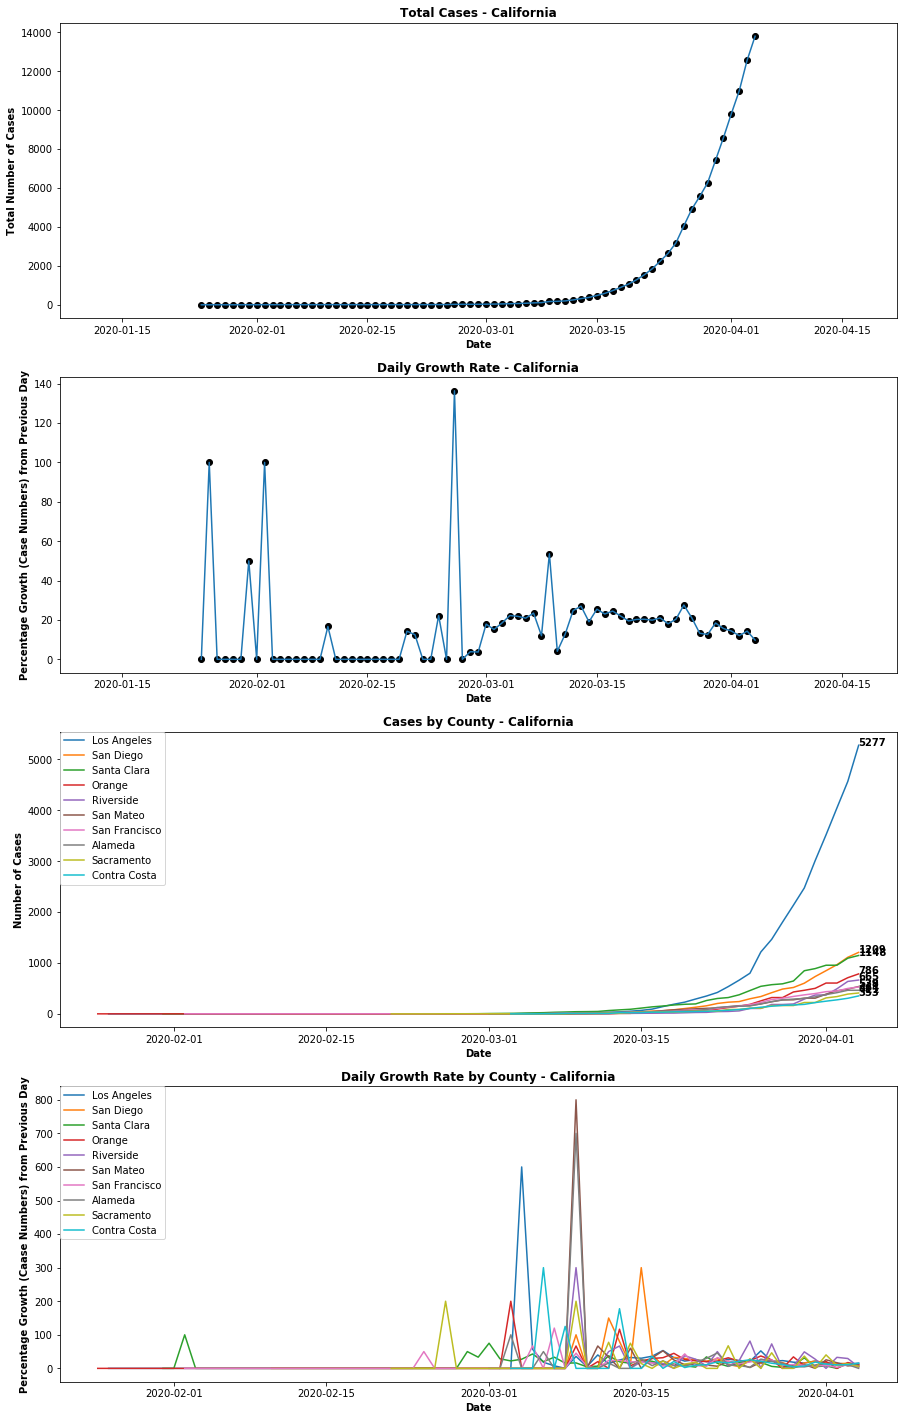

In [18]:
analyze_state("California")

Colorado reported its first cases of COVID-19 on 2020-03-05 00:00:00, and has 4574 cases as of 2020-04-04 00:00:00

The previous daily growth rate was 9.37%

The 3 day average growth rate was 10.99%

The 7 day average growth rate was 12.07%

The 10 most effected counties in Colorado:


,county,first_case,total_cases,previous_day_growth_rate,3day_avg_growth_rate,7day_avg_growth_rate
0,Denver,2020-03-06,769,7.4%,9.49%,11.18%
1,Arapahoe,2020-03-09,552,10.4%,13.18%,15.42%
2,Jefferson,2020-03-05,483,9.77%,10.73%,15.04%
3,Weld,2020-03-13,424,11.87%,13.12%,14.87%
4,El Paso,2020-03-06,406,8.56%,8.95%,12.02%
5,Eagle,2020-03-06,333,0.0%,4.16%,9.38%
6,Adams,2020-03-12,320,8.84%,14.47%,19.27%
7,Douglas,2020-03-05,209,7.73%,9.8%,12.52%
8,Boulder,2020-03-14,159,11.19%,11.77%,9.59%
9,Larimer,2020-03-09,144,7.46%,10.47%,8.99%


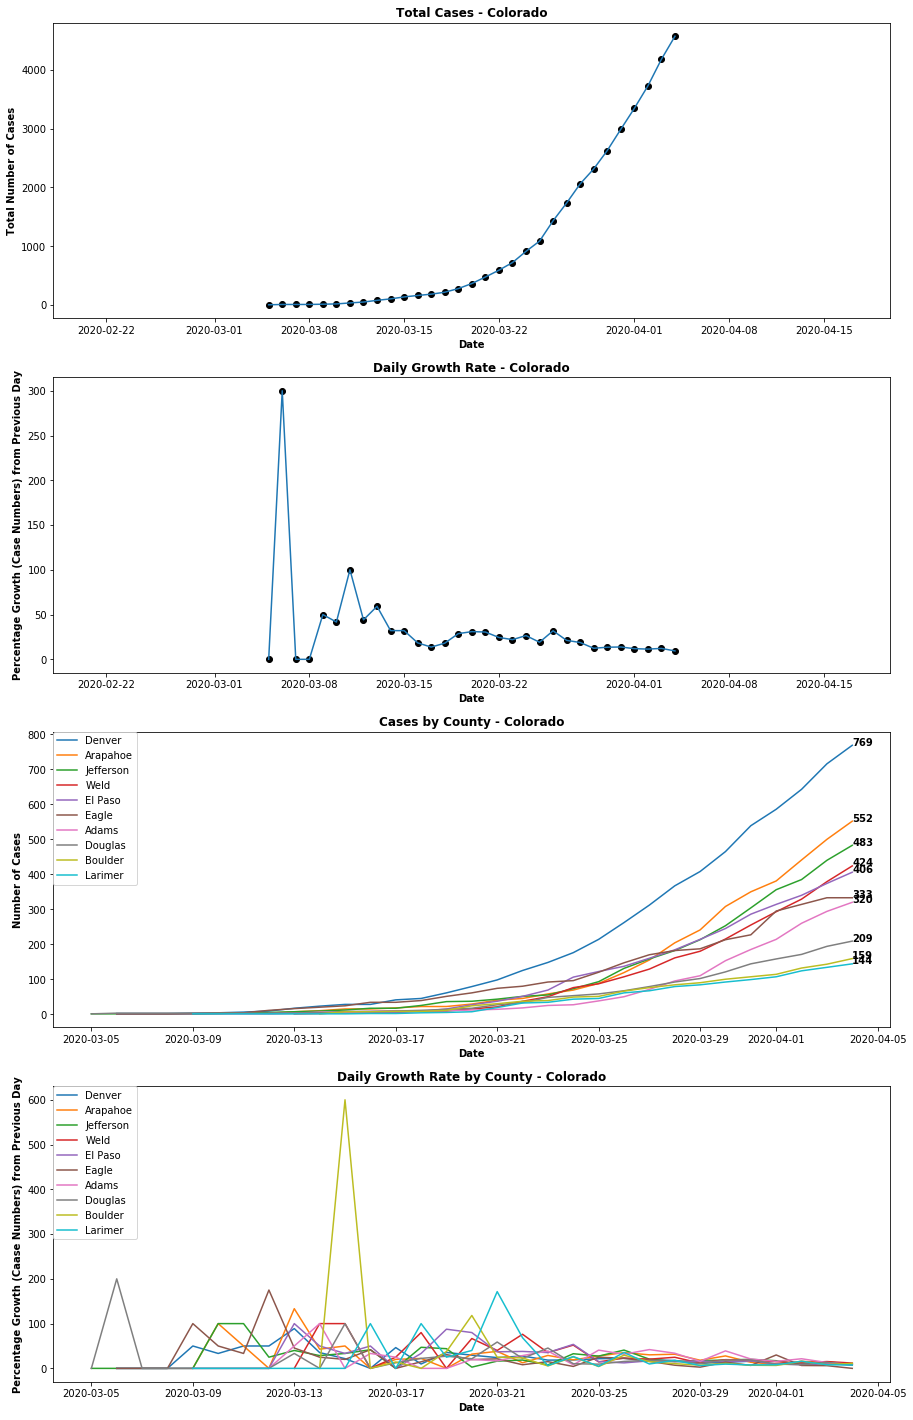

In [19]:
analyze_state("Colorado")

Illinois reported its first cases of COVID-19 on 2020-01-24 00:00:00, and has 10357 cases as of 2020-04-04 00:00:00

The previous daily growth rate was 16.32%

The 3 day average growth rate was 14.09%

The 7 day average growth rate was 16.7%

The 10 most effected counties in Illinois:


,county,first_case,total_cases,previous_day_growth_rate,3day_avg_growth_rate,7day_avg_growth_rate
0,Cook,2020-01-24,7439,14.92%,13.08%,16.36%
1,Lake,2020-03-11,689,13.32%,13.04%,14.73%
2,Will,2020-03-16,606,33.19%,23.64%,21.96%
3,DuPage,2020-03-14,590,18.0%,14.63%,16.81%
4,Kane,2020-03-10,207,17.61%,13.45%,12.67%
5,McHenry,2020-03-10,122,19.61%,20.98%,14.89%
6,St. Clair,2020-03-14,80,40.35%,15.92%,25.54%
7,Kankakee,2020-03-18,74,8.82%,9.2%,16.18%
8,Champaign,2020-03-22,55,7.84%,18.92%,20.89%
9,Kendall,2020-03-18,47,27.03%,21.05%,23.88%


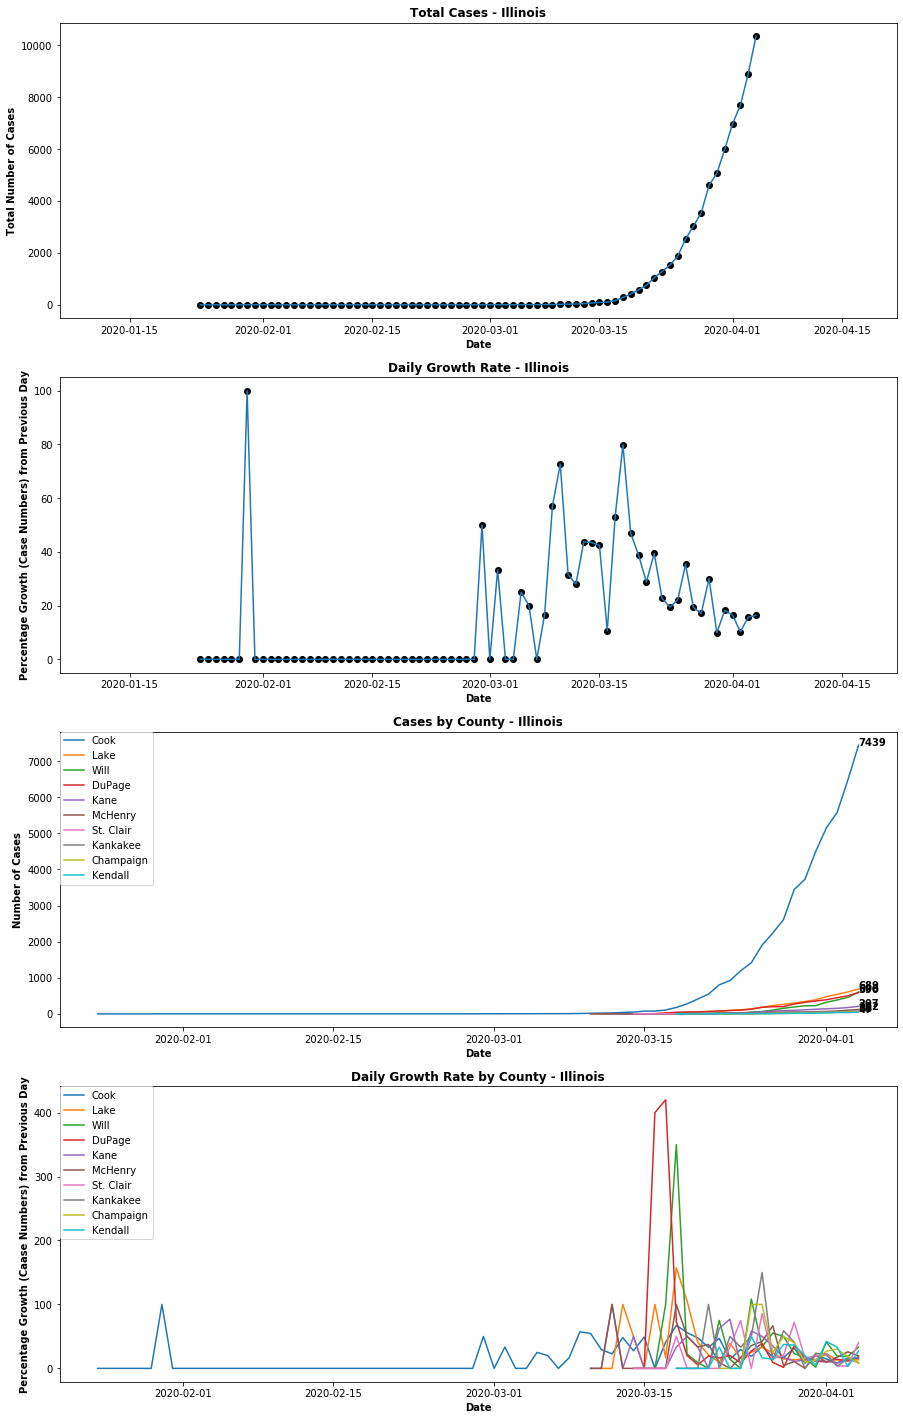

In [20]:
analyze_state("Illinois")

New York reported its first cases of COVID-19 on 2020-03-01 00:00:00, and has 114996 cases as of 2020-04-04 00:00:00

The previous daily growth rate was 11.79%

The 3 day average growth rate was 11.09%

The 7 day average growth rate was 11.6%

The 10 most effected counties in New York:


,county,first_case,total_cases,previous_day_growth_rate,3day_avg_growth_rate,7day_avg_growth_rate
0,New York City,2020-03-01,63307,10.75%,10.1%,10.87%
1,Nassau,2020-03-05,13346,10.99%,11.79%,13.41%
2,Westchester,2020-03-04,13080,5.91%,6.98%,7.52%
3,Suffolk,2020-03-08,12328,21.41%,17.5%,16.91%
4,Rockland,2020-03-06,4872,13.59%,13.63%,14.44%
5,Orange,2020-03-12,2741,14.35%,16.01%,13.95%
6,Erie,2020-03-15,945,17.83%,19.94%,15.55%
7,Dutchess,2020-03-12,938,15.95%,19.72%,20.04%
8,Monroe,2020-03-11,512,10.34%,13.72%,14.34%
9,Onondaga,2020-03-16,349,15.95%,12.28%,15.6%


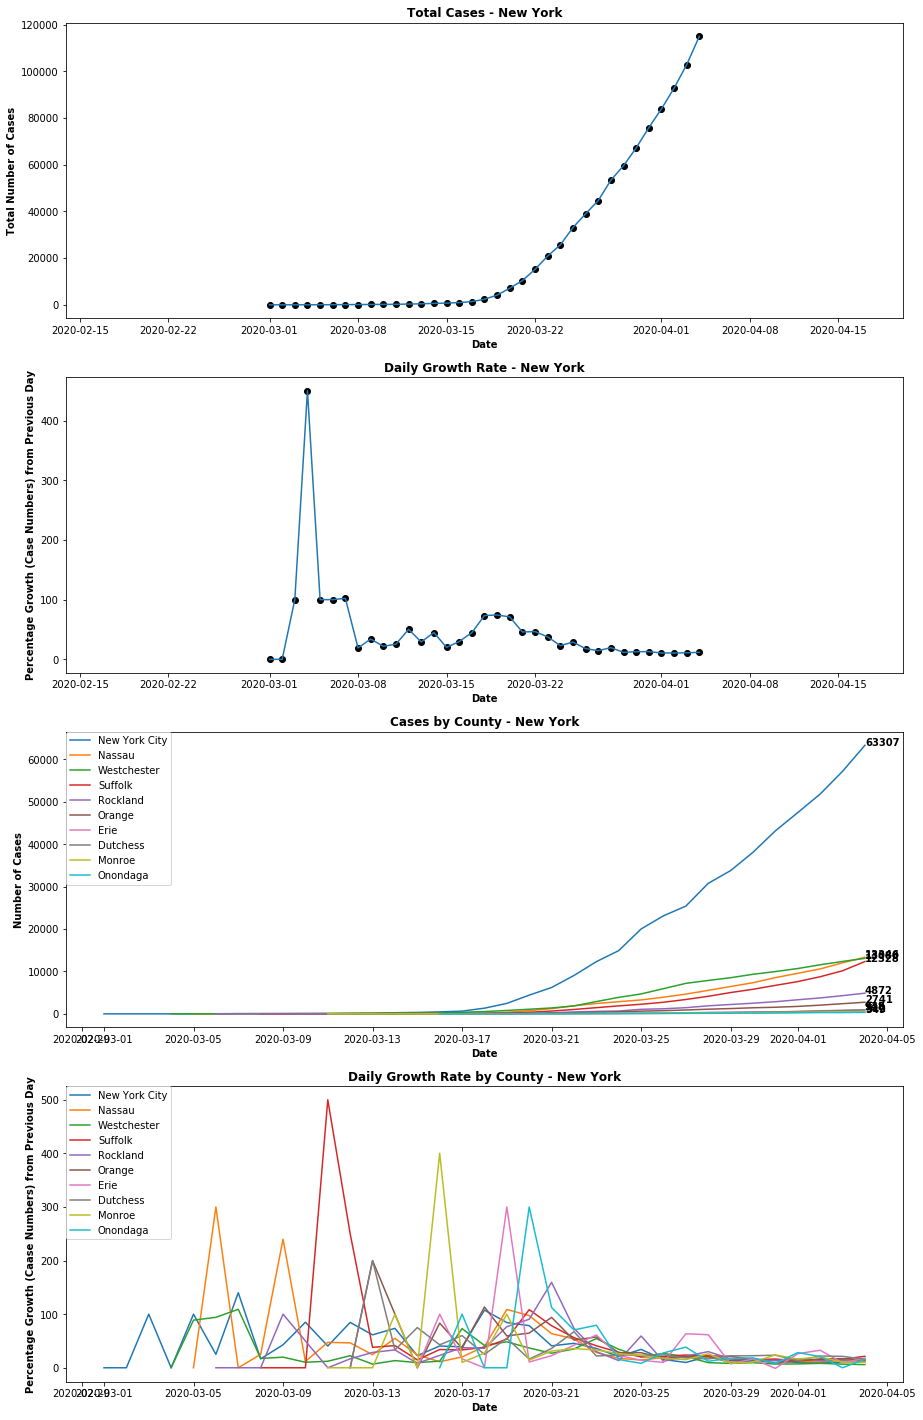

In [21]:
analyze_state("New York")

### GET N COUNTIES WITH MOST ACTIVE CASES

In [22]:
def get_most(county, n):
    
    most_recent = county[county.date == county.date.max()]
    
    hotspots = most_recent.sort_values(by = ["cases"], ascending = False).iloc[:n].fips
    
    fig, ax = plt.subplots(figsize = (15, 8))
    
    for cty in hotspots:
        
        county_dates = county[county.fips == cty].date
        
        county_cases = county[county.fips == cty].cases
        
        ax.scatter(county_dates, county_cases)

        ax.plot(county_dates, county_cases, label = county[county.fips == cty].county.max())
        
        ax.text(county_dates.iloc[-1], county_cases.iloc[-1], county_cases.iloc[-1],
                        horizontalalignment='left', weight = "bold")
        
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

    ax.set_title("{} Counties With Most Cases".format(n), weight = "bold")

    ax.set_xlabel("Date", weight = "bold")

    ax.set_ylabel("Number of Cases", weight = "bold");

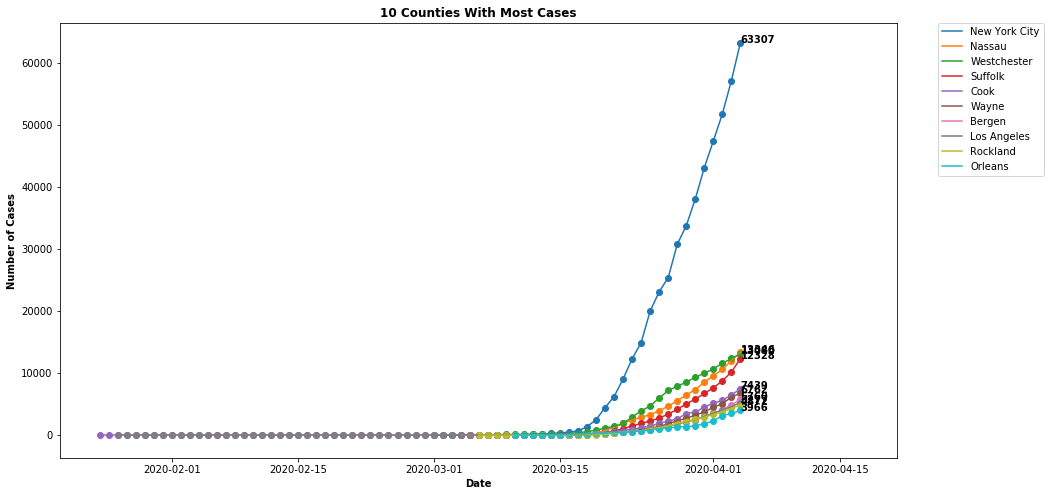

In [23]:
get_most(all_county, 10)

### EXPLORING TESTING DATA- COURTESY OF COVID TRACKING PROJECT

In [24]:
testing.head()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
0,20200404,AK,171.0,5869.0,NaN,NaN,16.0,NaN,NaN,NaN,...,16.0,6040,6040,6040,2,2.0,1.0,10.0,14.0,24.0
1,20200404,AL,1580.0,9273.0,NaN,NaN,212.0,NaN,NaN,NaN,...,212.0,10853,10853,10853,1,8.0,212.0,1086.0,148.0,1234.0
2,20200404,AR,743.0,9627.0,NaN,72.0,NaN,NaN,NaN,23.0,...,NaN,10370,10370,10370,5,2.0,0.0,632.0,39.0,671.0
3,20200404,AS,NaN,20.0,6.0,NaN,NaN,NaN,NaN,NaN,...,NaN,26,20,20,60,0.0,0.0,0.0,0.0,0.0
4,20200404,AZ,2019.0,25141.0,NaN,NaN,297.0,NaN,104.0,NaN,...,297.0,27160,27160,27160,4,11.0,48.0,2237.0,250.0,2487.0


In [25]:
testing["date"] = pd.to_datetime(testing.date, format = "%Y%m%d")

testing = testing.sort_values(by = ["state", "date"]).reset_index(drop = True)

In [26]:
pd.set_option("max.columns", 50)

testing.head()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,hash,dateChecked,death,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
0,2020-03-06,AK,0.0,8.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,b95ff00414e9a5542ba2aa08fdfda0b023c7c69c,2020-03-06T21:00:00Z,NaN,NaN,9,8,8,2,NaN,NaN,NaN,NaN,NaN
1,2020-03-07,AK,0.0,12.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71953eb42494f6000afda41cda80b1b3dc836a83,2020-03-07T21:00:00Z,NaN,NaN,14,12,12,2,0.0,0.0,4.0,0.0,4.0
2,2020-03-08,AK,0.0,14.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,844624448b0ee3ff7dd240e0d3f4258de1563064,2020-03-08T20:00:00Z,NaN,NaN,20,14,14,2,0.0,0.0,2.0,0.0,2.0
3,2020-03-09,AK,0.0,23.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,b5cbe627dd51a6e70136134185391030f93ffcb5,2020-03-09T20:00:00Z,NaN,NaN,32,23,23,2,0.0,0.0,9.0,0.0,9.0
4,2020-03-10,AK,0.0,23.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6561feac0f53ef762911b4995038df195c62b2cb,2020-03-10T20:00:00Z,NaN,NaN,32,23,23,2,0.0,0.0,0.0,0.0,0.0


### Positive Result Rate: The ratio of n_positive / n_negative

In [27]:
def positive_test_rate(st: str or list, data = testing):
    
    fig, ax = plt.subplots(figsize = (15, 8))
    
    if type(st) == str:
    
        if len(state) > 2:

            raise ValueError("Please pass two digit state code")

        state_testing = testing[testing.state == st].reset_index(drop = True)

        print("NOTE: THIS IS THE RATIO OF POSITIVE TESTS TO TEST RESULTS... PENDING TESTS ARE NOT\
         ACCOUNTED FOR AS THE DATA IS NOT COMPLETE")

        ax.plot(state_testing.date, (state_testing.positive / state_testing.totalTestResults) * 100, 
                c = "r", label = "Pos/Neg Ratio")

        ax.text(state_testing.date.max(), 
                (state_testing.iloc[-1]["positive"] / state_testing.iloc[-1]["totalTestResults"]) * 100,
                "{}%".format(round(
                    (state_testing.iloc[-1]["positive"] / state_testing.iloc[-1]["totalTestResults"]) * 100,
                                  2)), horizontalalignment = "left", verticalalignment = "center", c = "b", size = 11)

        ax.grid(True)

        ax.set_title("Ratio of Confirmed Positive to Total Test Results - {}".format(state), 
                     weight = "bold", size = 15)

        ax.set_xlabel("Date", weight = "bold", size = 12)

        ax.set_ylabel("Percentage of Positive Tests", weight = "bold",
                     size = 12);
        
    else:
        
        print("NOTE: THIS IS THE RATIO OF POSITIVE TESTS TO TEST RESULTS... PENDING TESTS ARE NOT\
             ACCOUNTED FOR AS THE DATA IS NOT COMPLETE")
        
        for state in st:
            
            if len(state) > 2:

                raise ValueError("Please pass two digit state code")

            state_testing = testing[testing.state == state].reset_index(drop = True)

            ax.plot(state_testing.date, (state_testing.positive / state_testing.totalTestResults) * 100, 
                    label = state)

            ax.text(state_testing.date.max(), 
                    (state_testing.iloc[-1]["positive"] / state_testing.iloc[-1]["totalTestResults"]) * 100,
                    "{}%".format(
                        round((state_testing.iloc[-1]["positive"] / state_testing.iloc[-1]["totalTestResults"]) * 100,
                                      2)), horizontalalignment = "left", verticalalignment = "center", c = "b", size = 11)

            ax.grid(True)

        ax.set_title("Ratio of Confirmed Positive to Total Test Results", 
                     weight = "bold", size = 15)

        ax.set_xlabel("Date", weight = "bold", size = 12)

        ax.set_ylabel("Percentage of Positive Tests", weight = "bold",
                         size = 12)
        
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0); 

NOTE: THIS IS THE RATIO OF POSITIVE TESTS TO TEST RESULTS... PENDING TESTS ARE NOT             ACCOUNTED FOR AS THE DATA IS NOT COMPLETE


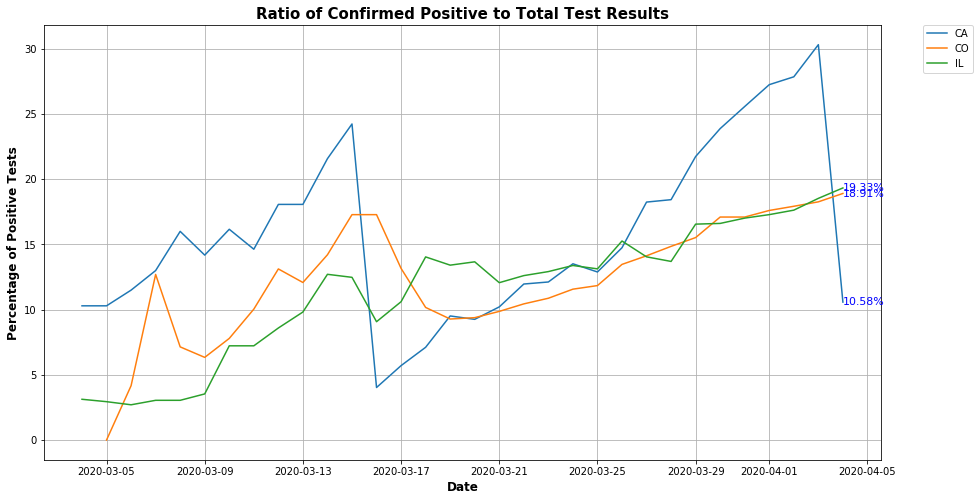

In [28]:
positive_test_rate(["CA", "CO", "IL"])

## Percentage of Positive/Total Test (CONFIRMED RESULTS) V. MORTALITY RATE- DEFINED AS NUMBER OF COVID DEATHS / NUMBER OF CONFIRMED POSITIVE RESULTS

In [30]:
def pos_v_mort(data = testing):
    
    most_recent = data[data.date == data.date.max()].reset_index(drop = True)
    
    territories = ["VI", "AS", "MP", "GU", "PR"]

    drop_indices = []

    for k in range(len(most_recent)):

        if most_recent.iloc[k]["state"] in territories:

            drop_indices.append(k)
            
    most_recent = most_recent.drop(drop_indices, axis = 0).reset_index(drop = True)
    
    most_recent["pos_ratio"] = most_recent.positive / most_recent.totalTestResults

    ##I am defining death rate as: number of COVID deaths / number of positive test results
    most_recent["mortality_rate"] = most_recent.death / most_recent.positive

    fig, ax = plt.subplots(figsize = (10, 10))

    color_scheme = np.where(most_recent.pos_ratio > most_recent.pos_ratio.mean(), 'red', 'blue')

    ax.set_facecolor("xkcd:off white")

    ax.scatter(most_recent.pos_ratio * 100, most_recent.mortality_rate * 100, c = color_scheme, edgecolor = "w")

    ax.axvline(most_recent.pos_ratio.mean() * 100, c = "k", ls = "--", alpha = 0.5)

    ax.axhline(most_recent.mortality_rate.mean() * 100, c = "k", ls = "--", alpha = 0.5)
    
    z = np.polyfit(most_recent.pos_ratio * 100, most_recent.mortality_rate * 100, 1)

    p = np.poly1d(z)

    ax.plot(most_recent.pos_ratio * 100, p(most_recent.pos_ratio * 100), ls = "-", c = "k", alpha = 0.5)

    for i, state in enumerate(most_recent.state.values):

        ax.annotate(state, (most_recent.pos_ratio.values[i] * 100, most_recent.mortality_rate.values[i] * 100))

    text_box = {

                "boxstyle" : "square",

                "facecolor" : "xkcd:powder blue",

                "edgecolor" : "k",

                "alpha" : 0.75
            }

    text = "\n".join((
        "Avg Positive Test Rate: {}%".format(round(most_recent.pos_ratio.mean()*100, 2)),
        "Avg Mortality Rate: {}%".format(round(most_recent.mortality_rate.mean()*100, 2))
    ))

    ax.grid(True, alpha = 0.25)

    ax.text(0.99, 0.99, text, transform = ax.transAxes, fontsize = 12, horizontalalignment = "right",
            verticalalignment = "top", bbox = text_box)

    ax.set_title("Ratio of Positive Tests v. Mortality Rate - {}".format(most_recent.date.max()), weight = "bold",
                size = 12)

    ax.set_xlabel("Percentage of Positive Tests", weight = "bold", size = 12)

    ax.set_ylabel("Mortality Rate (%)", weight = "bold", size = 12);

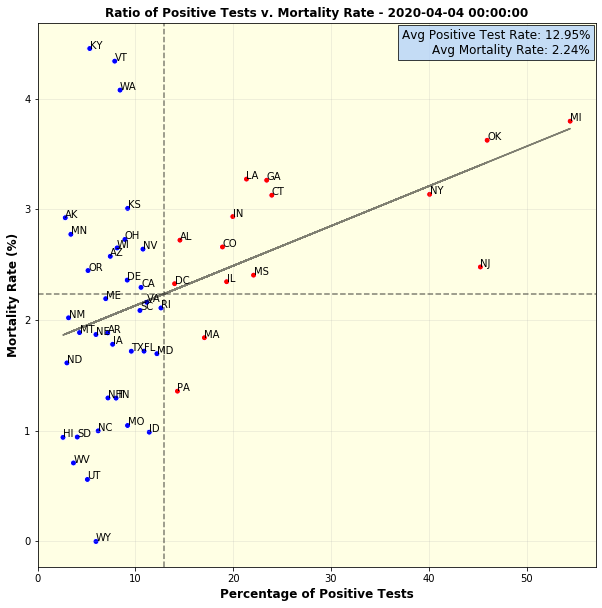

In [31]:
pos_v_mort()